# simulation of the historical x2 and x3 leverage of nasdaq 100

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

# Query data from Yahoo Finance
nasdaq100_data = yf.download('^NDX', start='1985-01-01')
qld_data = yf.download('QLD', start='2006-06-21')  # QLD's inception date
tqqq_data = yf.download('TQQQ', start='2010-02-09')  # TQQQ's inception date

# Calculate x2 and x3 leverage for Nasdaq 100
nasdaq100_data['Returns'] = nasdaq100_data['Adj Close'].pct_change()
nasdaq100_data['Sim_x2'] = (1 + 2 * nasdaq100_data['Returns']).cumprod()
nasdaq100_data['Sim_x3'] = (1 + 3 * nasdaq100_data['Returns']).cumprod()

# Drop NaN values in the simulated leverage columns
nasdaq100_data = nasdaq100_data.dropna(subset=['Sim_x2', 'Sim_x3'])

# Align dates for QLD and simulated x2 leverage
sim_x2_qld = nasdaq100_data['Sim_x2'].reindex(qld_data.index).dropna()
qld_data_aligned = qld_data['Adj Close'].reindex(sim_x2_qld.index).dropna()

# Train a linear model for QLD
x2_model = LinearRegression()
x2_model.fit(sim_x2_qld.values.reshape(-1, 1), qld_data_aligned.values)
transformed_x2 = x2_model.predict(nasdaq100_data['Sim_x2'].values.reshape(-1, 1))

# Align dates for TQQQ and simulated x3 leverage
sim_x3_tqqq = nasdaq100_data['Sim_x3'].reindex(tqqq_data.index).dropna()
tqqq_data_aligned = tqqq_data['Adj Close'].reindex(sim_x3_tqqq.index).dropna()

# Train a linear model for TQQQ
x3_model = LinearRegression()
x3_model.fit(sim_x3_tqqq.values.reshape(-1, 1), tqqq_data_aligned.values)
transformed_x3 = x3_model.predict(nasdaq100_data['Sim_x3'].values.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


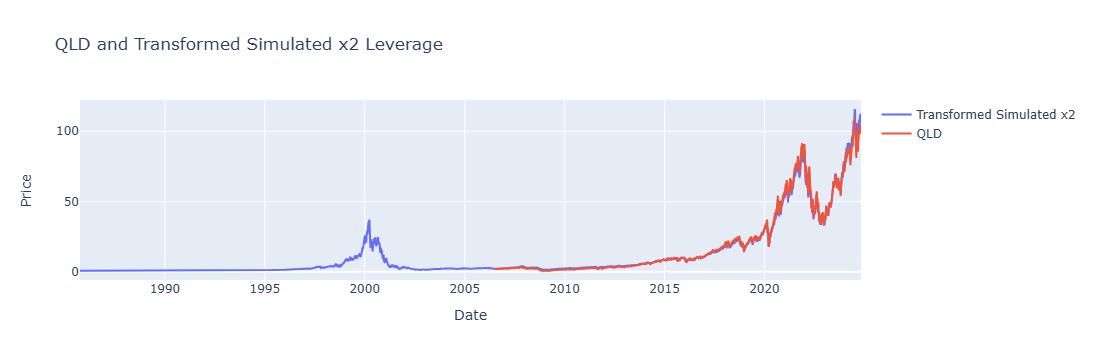

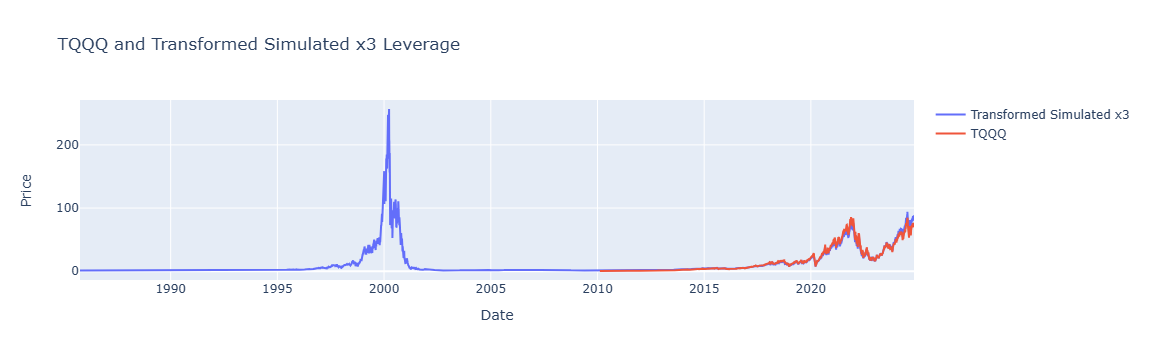

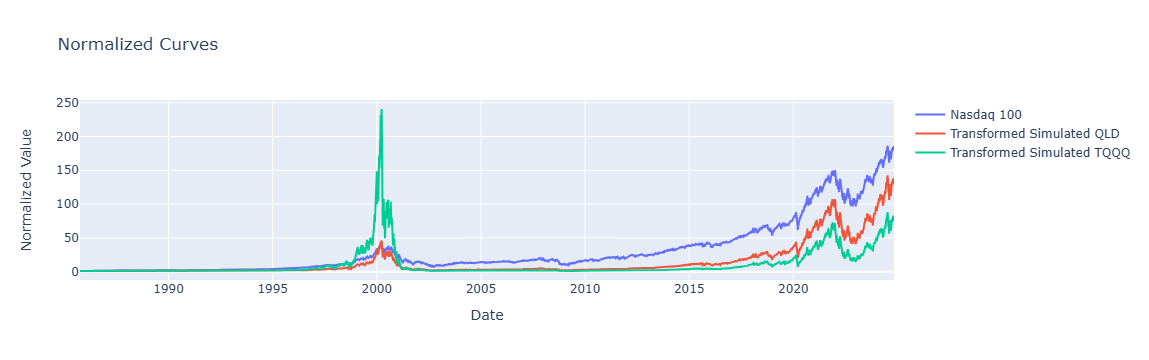

In [10]:
# Plot QLD and transformed simulated x2 leverage
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=nasdaq100_data.index, y=transformed_x2, mode='lines', name='Transformed Simulated x2'))
fig1.add_trace(go.Scatter(x=qld_data_aligned.index, y=qld_data_aligned, mode='lines', name='QLD'))
fig1.update_layout(title="QLD and Transformed Simulated x2 Leverage", xaxis_title="Date", yaxis_title="Price")
fig1.show()

# Plot TQQQ and transformed simulated x3 leverage
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=nasdaq100_data.index, y=transformed_x3, mode='lines', name='Transformed Simulated x3'))
fig2.add_trace(go.Scatter(x=tqqq_data_aligned.index, y=tqqq_data_aligned, mode='lines', name='TQQQ'))
fig2.update_layout(title="TQQQ and Transformed Simulated x3 Leverage", xaxis_title="Date", yaxis_title="Price")
fig2.show()

# Calculate ratio over the first day for normalized curves
nasdaq100_ratio = nasdaq100_data['Adj Close'] / nasdaq100_data['Adj Close'].iloc[0]
transformed_x2_ratio = transformed_x2 / transformed_x2[0]
transformed_x3_ratio = transformed_x3 / transformed_x3[0]

# Plot normalized curves
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=nasdaq100_data.index, y=nasdaq100_ratio, mode='lines', name='Nasdaq 100'))
fig3.add_trace(go.Scatter(x=nasdaq100_data.index, y=transformed_x2_ratio, mode='lines', name='Transformed Simulated QLD'))
fig3.add_trace(go.Scatter(x=nasdaq100_data.index, y=transformed_x3_ratio, mode='lines', name='Transformed Simulated TQQQ'))
fig3.update_layout(title="Normalized Curves", xaxis_title="Date", yaxis_title="Normalized Value")
fig3.show()

# return of holding x years

In [11]:
nasdaq100_data['transformed_x2'] = transformed_x2
nasdaq100_data['transformed_x3'] = transformed_x3

In [12]:
nasdaq100_data.head(3)

Open        High         Low       Close   Adj Close  \
Date                                                                     
1985-10-02  112.139999  112.540001  110.779999  110.824997  110.824997   
1985-10-03  110.839996  111.184998  110.120003  110.870003  110.870003   
1985-10-04  110.870003  110.870003  109.855003  110.074997  110.074997   

               Volume   Returns    Sim_x2    Sim_x3  transformed_x2  \
Date                                                                  
1985-10-02  164640000 -0.011726  0.976547  0.964821        0.813113   
1985-10-03  147300000  0.000406  0.977340  0.965996        0.813151   
1985-10-04  147900000 -0.007171  0.963324  0.945216        0.812484   

            transformed_x3  
Date                        
1985-10-02        1.067259  
1985-10-03        1.067311  
1985-10-04        1.066406

In [13]:
import pandas as pd
import numpy as np

# Sample data for demonstration purposes. Make sure 'Date' is set as the index
# nasdaq100_data = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)

# Specify the columns for which we want to calculate returns
price_columns = ['Adj Close', 'transformed_x2', 'transformed_x3']
holding_periods = [1, 2, 5, 10, 20, 30]  # holding periods in years

# Calculate returns for each holding period using a sliding window
results = {}

# Convert holding periods to the number of days (assuming 252 trading days per year)
for period in holding_periods:
    days = period * 252  # Approximate trading days per year

    # Dictionary to store median returns for each price column
    period_returns = {}

    for col in price_columns:
        # Calculate the sliding window returns for the current holding period
        returns = (nasdaq100_data[col].shift(-days) / nasdaq100_data[col] - 1).dropna()

        # Store the median return for the holding period
        period_returns[col] = returns.median()

    # Save the results for the current holding period
    results[f'{period}_years_median_return'] = period_returns

# Convert the results to a DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df

1_years_median_return  2_years_median_return  \
Adj Close                    0.171149               0.302113   
transformed_x2               0.140831               0.292659   
transformed_x3               0.124713               0.239821   

                5_years_median_return  10_years_median_return  \
Adj Close                    1.010971                2.584878   
transformed_x2               0.877928                2.106862   
transformed_x3               0.755217                1.603788   

                20_years_median_return  30_years_median_return  
Adj Close                     7.639522               38.823669  
transformed_x2                3.193579               31.356272  
transformed_x3                0.543378               12.954309